In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
#read data
data = pd.read_csv(r'../data/music.csv')

In [3]:
# take a look at data
data.head()

,artist.hotttnesss,artist.id,artist.name,artist_mbtags,artist_mbtags_count,bars_confidence,bars_start,beats_confidence,beats_start,duration,...,start_of_fade_out,tatums_confidence,tatums_start,tempo,terms,terms_freq,time_signature,time_signature_confidence,title,year
0,0.401998,ARD7TVE1187B99BFB1,Casual,NaN,0.0,0.643,0.58521,0.834,0.58521,218.93179,...,218.932,0.779,0.28519,92.198,hip hop,1.000000,4.0,0.778,I Didn't Mean To,0
1,0.417500,ARMJAGH1187FB546F3,The Box Tops,classic pop and rock,1.0,0.007,0.71054,1.000,0.20627,148.03546,...,137.915,0.969,0.20627,121.274,blue-eyed soul,1.000000,4.0,0.384,Soul Deep,1969
2,0.343428,ARKRRTF1187B9984DA,Sonora Santanera,NaN,0.0,0.980,0.73152,0.980,0.73152,177.47546,...,172.304,0.482,0.42132,100.070,salsa,1.000000,1.0,0.000,Amor De Cabaret,0
3,0.454231,AR7G5I41187FB4CE6C,Adam Ant,uk,1.0,0.017,1.30621,0.809,0.81002,233.40363,...,217.124,0.601,0.56254,119.293,pop rock,0.988584,4.0,0.000,Something Girls,1982
4,0.401724,ARXR32B1187FB57099,Gob,NaN,0.0,0.175,1.06368,0.883,0.13576,209.60608,...,198.699,1.000,0.13576,129.738,pop punk,0.887288,4.0,0.562,Face the Ashes,2007


In [4]:
# features we have in raw dataset
data.columns

Index(['artist.hotttnesss', 'artist.id', 'artist.name', 'artist_mbtags',
       'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year'],
      dtype='object')

In [5]:
X = data.drop(columns = ['artist.id', 'artist.name','artist_mbtags',
                        'artist_mbtags_count','familiarity','mode',
                         'mode_confidence','release.id','release.name',
                        'song.hotttnesss','song.id','terms_freq',
                         'title','year','terms','longitude','latitude',
                        'location'])

In [6]:
print('we have {} features in the raw dataset'.format(len(data.columns)))

we have 35 features in the raw dataset


**Documentation of feature selection and manipulation**

+ Artist familiarity and artist hotness are not strictly the same thing. Familiar artists can refer to some historically famous aritist such as Beatles,Michael Jackson. Hot artists are usually contemporary, such as Katy Perry, the Boy Least Likely to, and Mastodon. See this link for more details[link](https://musicmachinery.com/2009/05/25/artist-similarity-familiarity-and-hotness/). However, because in most other cases, contemporarily hot artists are also familiar, they have a very high correlation and therefore we decide to only keep artist hotness.
+ artist id,song id, release id, should not have anything to do with response, so we drop them.
+ Localtion selection bias: this dataset contains all the songs inside USA but only the HOT songs from outside USA. Then the naive model will tends to learn the location as a false "strong" predictor where songs from overseas is hot.**Therefore we drop all location-related attributes**
+ Longitude and latitude are very strange: they seldom change despite big changes in location, therefore we drop them. See the maps below for evidence that these information are wrong.
+ Instead of using year, we created a feature named "Decade" because 10-year period should be sufficient to capture changes in audience taste or music genre while the specific year is too detailed and unnecessary.
+ Location is very dirty with inconsistent format. We extracted country and region from these strings and confirmed the existence of selection bias in this dataset.(see below for details)
+ "mode" is whether the song used a major or minor key. We plotted the distributions of hotness stratified on mode, and found that the distributions are exactly the same. Therefore, there is no need to inlcude this feature(and the associated mode confidence)
+ artist name cannot be directly used in our final model, we will drop for now. **It can be helpful when we augment the dataset with other features related to this artist.**
+ Artist mbtags and terms refer to the style of the artist and song. We decide to only retain terms for now.
+ Release name is the album name containing the song, we decide to drop it and only focus on the song.
+ All the others are characteristics quantitatively describing the piece of music, therefore we retain them all for now.
+ "similar" refers to similar artists(recorded as id). We drop it for now.

**Music-related quantitative measures like beat, bars etc**
we notice that music related quantitative measures are correlated with each other. ***We should therefore avoid using linear regression or other methods vulnerable to this characteristic.***

<Figure size 1440x1440 with 0 Axes>

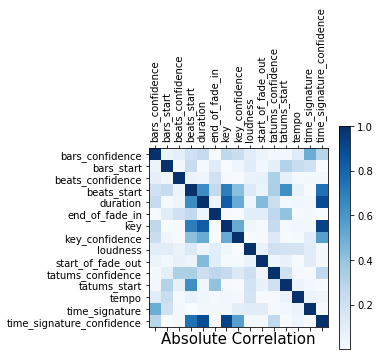

In [7]:
music_related = ['bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
                'key', 'key_confidence','loudness','start_of_fade_out', 
                 'tatums_confidence', 'tatums_start', 'tempo',
                'time_signature', 'time_signature_confidence',
                 'location','similar'];
plt.figure(figsize=(20,20));
corr = data[music_related].corr();
plt.matshow(abs(corr),cmap = 'Blues');
plt.colorbar();
plt.xlabel("Absolute Correlation",fontsize=15)
plt.xticks(range(len(corr.columns)), corr.columns,rotation = 'vertical');
plt.yticks(range(len(corr.columns)), corr.columns);


Notice that we have 459 different values for 'terms', therefore this attribute needs further processing

In [8]:
len(data['terms'].unique())

459

**Next we extract country and region from location**

In [9]:
import hvplot.pandas
import geoviews as gv
tiles=gv.tile_sources.Wikipedia

In [10]:
%%output size=120
data.hvplot.points('longitude', 'latitude',geo=True,alpha=0.2,title='Songs Quantity and geographic position')*tiles

:Overlay
   .Points.I :Points   [longitude,latitude]
   .WMTS.I   :WMTS   [Longitude,Latitude]

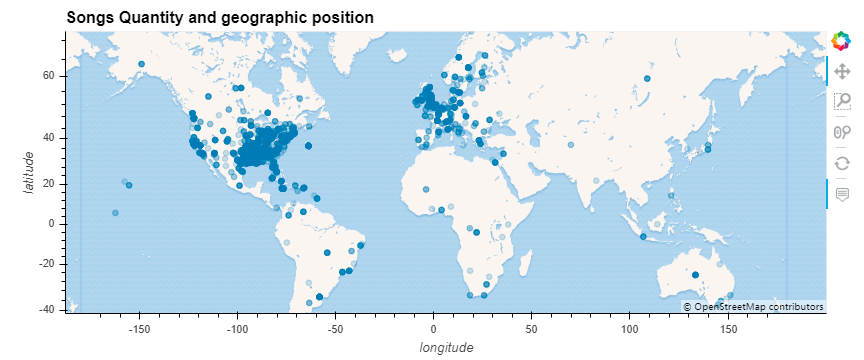

Most of the songs are from east and west coasts of USA, but there are also many songs from outside of USA, such as middle east and south America. This introduce a **selection bias** where this dataset contains all the songs inside USA but only the HOT songs from outside USA. Then the naive model will tends to learn the location as a false "strong" predictor where songs from overseas is hot.

In [11]:
%%output size=120
data.hvplot.points('longitude', 'latitude', c='song.hotttnesss',cmap=plt.get_cmap('hot_r'),geo=True,alpha=0.8,title='Songs hotness and geographic position')*tiles

:Overlay
   .Points.I :Points   [longitude,latitude]   (song.hotttnesss)
   .WMTS.I   :WMTS   [Longitude,Latitude]

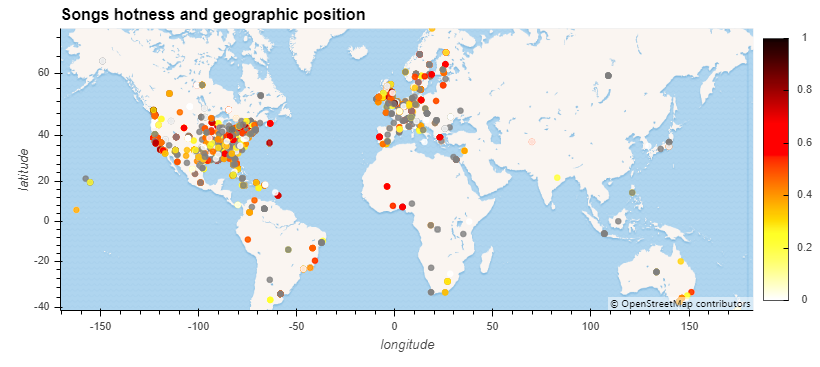

When plot the hotness and geographical distribution, we find that the eastern and middle USA have many hot songs.Grey points means missing value.
**From the map, we can see that longitude and latitude may be wrong because some points are in the ocean（which is not possible). So we will drop them for sure.**

Field names explanation see this [link](https://labrosa.ee.columbia.edu/millionsong/faq)

In [12]:
us_state_abbrev = {
    'alabama': 'al',
    'alaska': 'ak',
    'arizona': 'az',
    'arkansas': 'ar',
    'california': 'ca',
    'colorado': 'co',
    'connecticut': 'ct',
    'delaware': 'de',
    'florida': 'fl',
    'georgia': 'ga',
    'hawaii': 'hi',
    'idaho': 'id',
    'Illinois': 'il',
    'indiana': 'in',
    'iowa': 'ia',
    'kansas': 'ks',
    'kentucky': 'ky',
    'louisiana': 'la',
    'maine': 'me',
    'maryland': 'md',
    'massachusetts': 'ma',
    'michigan': 'mi',
    'minnesota': 'mn',
    'mississippi': 'ms',
    'missouri': 'mo',
    'montana': 'mt',
    'nebraska': 'ne',
    'nevada': 'nv',
    'new hampshire': 'nh',
    'new jersey': 'nj',
    'new mexico': 'nm',
    'new york': 'ny',
    'north carolina': 'nc',
    'north dakota': 'nd',
    'ohio': 'oh',
    'oklahoma': 'ok',
    'oregon': 'or',
    'pennsylvania': 'pa',
    'rhode island': 'ri',
    'south carolina': 'sc',
    'south dakota': 'sd',
    'tennessee': 'tn',
    'texas': 'tx',
    'utah': 'ut',
    'vermont': 'vt',
    'virginia': 'va',
    'washington': 'wa',
    'west virginia': 'wv',
    'wisconsin': 'wi',
    'wyoming': 'wy',
}

In [13]:
abbrev_to_states = {}
for key in us_state_abbrev.keys():
    abbrev_to_states[us_state_abbrev[key]] = key

In [14]:
# extract country and region from location
country = []
region = []
j = 0
for location in data['location']:
    j=j+1
    if location == 'Not available' or location == ' ':
        country.append('')
        #print(location)
        region.append('')
    else:
        location=location.replace('.','')
        location = location.lower()
        if ',' not in location:
            splitted_string = location.split()
            location = ' '.join(splitted_string[:-1])+','+splitted_string[-1]
        location_list = re.split(';| -|,|[|]|/',location)
        location_list = [i.strip() for i in location_list if i] 
        if 'chicago' in location_list and len(location_list)<2:
            location_list.append(abbrev_to_states['il'])
        if "boston" in location_list and len(location_list)>2:
            location_list.append(abbrev_to_states['ma'])
        #print(location_list)
        if location_list[-1] in abbrev_to_states or location_list[-1] in us_state_abbrev:
            country.append('united states')
            try:
                region.append(abbrev_to_states[location_list[-1]])
            except:
                region.append(location_list[-1])
        elif len(location_list)>=2 and (location_list[-2] in abbrev_to_states or location_list[-2] in us_state_abbrev):
            country.append('united states')
            try:
                region.append(abbrev_to_states[location_list[-2]])
            except:
                region.append(location_list[-2])
        
        else:
            if 'usa' in location_list[-1] or 'us' == location_list[-1]:
                country.append('usa')
                region.append(location_list[-1][:location_list[-1].find('U')])
            elif 'jersey' in location_list[-1]:
                country.append('usa')
                region.append('new jersey')
            elif 'lousiana' in location_list[-1]:
                # misspell
                country.append('usa')
                region.append('louisiana')
            elif 'engla' == location_list[-1]:
                country.append('england')
                region.append(location_list[-2])
            elif 'massachusettes' in location_list[-1]:
                country.append('usa')
                region.append('massachusetts')
            elif "angels" in location_list[-1] or "barbara" in location_list[-1]:
                country.append('usa')
                region.append('california')
            elif "seattle" in location_list[-1]:
                country.append('usa')
                region.append('washington')
            elif 'katy' in location_list[-1]:
                country.append('usa')
                region.append('texas')
            elif location_list[-1] in us_state_abbrev:
                country.append('usa')
                region.append(location_list[-1])
            else:
                country.append(location_list[-1])
                if len(location_list) >= 2:
                    region.append(location_list[-2])
                else:
                    region.append('')
    

In [15]:
data['country'] = country
data['region'] = region

In [16]:
hotness_by_country = data.groupby('country')['song.hotttnesss'].agg(['mean','size'])
hotness_by_country = hotness_by_country[hotness_by_country>0.6]
hotness_by_country.sort_values(by = 'mean',ascending = False).head(10)

,mean,size
country,,
oxford,0.728377,1
nigeria,0.664061,6
ldn,0.653728,4
united kingdom,0.647975,9
portugal,0.637547,5
colombia,0.628968,14
norrta$?lje,0.624071,2
borla$?nge,0.615553,4
barbados,0.614847,8


+ Notice that regions with high average hotness also have very few number of songs and they are all non-us regions.
+ We also notice that foreign countries tend to have high average hotness.

**Therefore,we suspect that that there is a record bias**: that the data collector, being us entity, will only record foreign songs that are already a big hit locally. Therefore, although we can see region is highly predictive of the song's hotness following this path of reasoning, we cannot predict a song's hotness based on the region they come from. Take "Oxford, England" as an example, it is not that songs from England is hot, but that only hit songs in Oxford are recorded by this dataset(collection based in U.S.).***To avoid this bias, we decide to drop all location-related attributes.***

**Motivation of dropping artist familiarity**

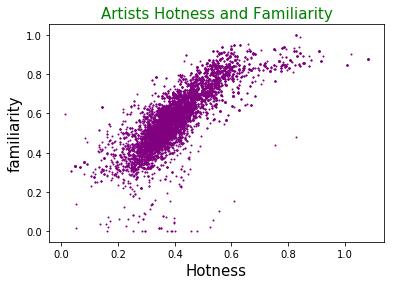

In [17]:
corr_df = data[['artist.hotttnesss','familiarity']]
corr_df = corr_df.loc[corr_df['artist.hotttnesss']!=0]
# I suspect that some hotness are missing and recoded as 0 so we
# remove them, otherwise there exists a vertical line at hotness = 0
plt.scatter(corr_df['artist.hotttnesss'],corr_df['familiarity'],s=1,color = 'purple');
plt.title('Artists Hotness and Familiarity',color = 'green',fontsize = 15);
plt.xlabel('Hotness',fontsize = 15);
plt.ylabel('familiarity',fontsize = 15);

In [18]:
corr, pvalue = pearsonr(corr_df['artist.hotttnesss'],corr_df['familiarity'])
print('correlation between artist hotness and familiarity', round(corr,2))
print('this is very significant as p-value is ',pvalue)

correlation between artist hotness and familiarity 0.81
this is very significant as p-value is  0.0


**Motivation of dropping mode from feature list**
Mode indicates whether a song used a major key(1).

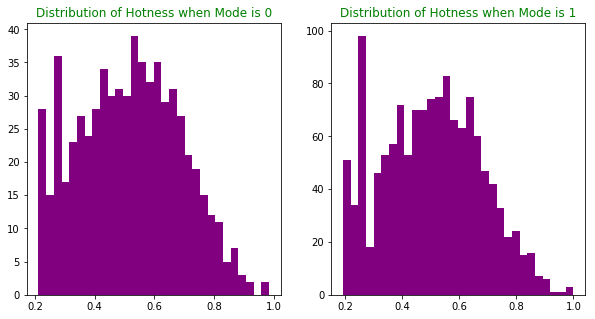

In [19]:
f,ax = plt.subplots(1,2,figsize = (10,5))
ax[1].set_title('Distribution of Hotness when Mode is 1',color = 'green')
ax[0].set_title('Distribution of Hotness when Mode is 0',color = 'green')
ax[0].hist(data.loc[data['mode'] == 0].loc[data['song.hotttnesss']!=0].dropna()['song.hotttnesss'],bins = 30,color = 'purple');
ax[1].hist(data.loc[data['mode'] == 1].loc[data['song.hotttnesss']!=0].dropna()['song.hotttnesss'],bins = 30,color = 'purple');

**Replacing year with decades**

In [20]:
result = []
for year in data.year:
    if year > 1000:
        result.append(str(year)[:3]+'0')
    else:
        result.append(np.nan)

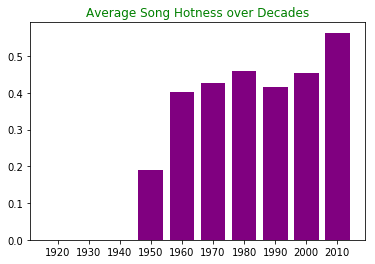

In [21]:
data['decade'] = result;
X['decade'] = result
year_df = data.groupby('decade')['song.hotttnesss'].mean();
year_clean = year_df.fillna(0);
plt.title('Average Song Hotness over Decades',color = 'green')
plt.bar(x = year_clean.index,height = year_clean.values, color = 'purple');
year_full = data.query('year>1000')

We notice that there is a tendency that more recent songs are rated higher. This makes intuitive sense because the hotness is the current hotness. 

**Studying Song Release pattern over time**

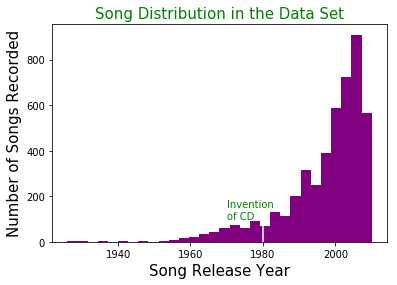

In [22]:
plt.title('Song Distribution in the Data Set',color = 'green',fontsize = 15);
plt.hist(year_full['year'],bins =30,color = 'purple');
plt.xlabel('Song Release Year',fontsize = 15);
plt.ylabel('Number of Songs Recorded',fontsize = 15);
plt.vlines(x = 1980,ymin =0,ymax = 800,color = 'white');
plt.text(x=1970,y=100,s='Invention \nof CD',color = 'green');

We observe that songs are released in large amount after 1980, which is when CD was invented and popularized.

**Potentially most predictive feature**

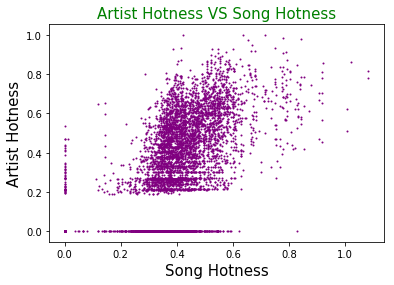

In [23]:
plt.title('Artist Hotness VS Song Hotness',color = 'green',fontsize = 15);
plt.scatter(data['artist.hotttnesss'],data['song.hotttnesss'],s = 1,color = 'purple');
plt.xlabel('Song Hotness',fontsize = 15);
plt.ylabel("Artist Hotness",fontsize = 15);

We observe that artist hotness is possibly the most predictive feature for song hotness. 

**Tokenize 'terms' and use tfidf scores as features**

tfidf score use the frequency a word appears to quantify its importance, while adjusting for the fact that common words appear most frequently with very little meaning. We believe it could be a good indicator because popular(tend to be hot) styles will appear more frequently.
**This part may need further processing to trim down the number of features we have, currently we have 381**

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
stop_words = set(stopwords.words('english'))
corpus = data['terms'].fillna('')

In [26]:
result = []
for i in corpus:
    song = ' '.join([j for j in i.split() if j not in stop_words])
    result.append(song)

In [27]:
vectorizer = TfidfVectorizer()
tf_df = vectorizer.fit_transform(corpus)

In [28]:
data.terms[0]

'hip hop'

In [29]:
# as an example 
print(tf_df[0,:])
# 0 indicates the 0th song, 175, and 177 indicates the respective words
print(vectorizer.vocabulary_['hip'])
print(vectorizer.vocabulary_['hop'])
print(tf_df.shape)

  (0, 175)	0.712195928590824
  (0, 177)	0.7019807399769983
175
177
(10000, 381)


In [30]:
# ready for further investigation
my_terms = tf_df.toarray()

In [31]:
addon_colnames = list(vectorizer.vocabulary_.keys())

In [32]:
addon_df = pd.DataFrame(my_terms,columns = addon_colnames)

In [33]:
one_hot_year = pd.get_dummies(X['decade'])
X = X.drop(columns = ['decade','similar'])

In [34]:
augmented_df = pd.concat([addon_df, X,one_hot_year], axis = 1)

In [35]:
y = data['song.hotttnesss']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(augmented_df, y, test_size=0.2, random_state=42)

In [37]:
regr = RandomForestRegressor(max_depth = 5, random_state=0,
                             n_estimators=100)